In [1]:
#!pip install obspy
#!pip install pyts

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# df_train = pd.read_csv("/kaggle/input/liverpool-ion-switching/train.csv")
# df_test = pd.read_csv("/kaggle/input/liverpool-ion-switching/test.csv")
df_train = pd.read_csv("train_clean_kalman.csv")
#df_new = pd.read_csv("test_clean_kalman.csv")

BATCH_SIZE = 500_000
for i in range(df_train.shape[0]//BATCH_SIZE):
    df_train.loc[i * BATCH_SIZE:((i + 1) * BATCH_SIZE) - 1, 'batch'] = i
    
GROUP_SIZE = 100_000
for i in range(df_train.shape[0]//GROUP_SIZE):
    df_train.loc[i * GROUP_SIZE:((i + 1) * GROUP_SIZE) - 1, 'group'] = i

# TODO: fix batches for test (niso na 500k ampak na 100k za prva 2 batcha)
#for i in range(4):
#    df_test.loc[i * BATCH_SIZE:((i + 1) * BATCH_SIZE) - 1, 'batch'] = i

df_train['batch'] = df_train['batch'].astype(np.uint8)
#df_test['batch'] = df_test['batch'].astype(np.uint8)

In [3]:
# GENERATE SEQUENCES

SEQ_LEN_BEFORE = 50
SEQ_LEN_AFTER = 50
SEQ_LEN = SEQ_LEN_BEFORE + 1 + SEQ_LEN_AFTER

def to_supervised(df, n_before=1, n_after=1):
    col = 'signal'
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_before, 0, -1):
        cols.append(df[col].shift(i).fillna(method='bfill'))
        names.append(f'shift_t-{i}')
    
    # (t)
    cols.append(df[col])
    names.append(f'shift_t')
    
    # (t+1, ... t+n)
    for i in range(1, n_after+1):
        #cols.append(df.shift(-i).fillna(method='ffill'))
        cols.append(df[col].shift(-i).fillna(method='ffill'))
        names.append(f'shift_t+{i}')

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

# df_train = to_supervised(df_train, SEQ_LEN_BEFORE, SEQ_LEN_AFTER)
df_new = to_supervised(df_new, SEQ_LEN_BEFORE, SEQ_LEN_AFTER)
print(df_train.shape)
#df_train_X.iloc[499_999:500010]

(2000000, 101)


In [4]:
import tsfel
from tqdm import tqdm

#cfg_file = tsfel.get_features_by_domain()
cfg_file = tsfel.load_json('features.json')

bsize = 100_000
for i in tqdm(range(50, df_train.shape[0] // bsize)):
    batch = df_train.iloc[i*bsize:(i+1)*bsize, :]
    df = tsfel.time_series_features_extractor(cfg_file, batch.to_numpy(), fs=10_000, verbose=0)
    df.to_csv('train_clean_kalman_feats_w101.csv', mode='a', header=(i==0))


  0%|                                                                                                                                                                     | 0/24 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                                 | 1/24 [33:31<12:50:56, 2011.14s/it]

  8%|████████████▌                                                                                                                                         | 2/24 [1:06:28<12:13:44, 2001.13s/it]

 12%|██████████████████▊                                                                                                                                   | 3/24 [1:39:47<11:40:07, 2000.38s/it]

 17%|█████████████████████████                                                                                                                             | 4/24 [2:12:51<11:05:06, 1995.34s/it]

 21%|███████████████████████████████▎                                                                                                                      | 5/24 [2:45:52<10:30:30, 1991.06s/it]

 25%|█████████████████████████████████████▊                                                                                                                 | 6/24 [3:18:32<9:54:34, 1981.90s/it]

 29%|████████████████████████████████████████████                                                                                                           | 7/24 [3:51:32<9:21:22, 1981.30s/it]

 33%|██████████████████████████████████████████████████▎                                                                                                    | 8/24 [4:24:13<8:46:41, 1975.08s/it]

 38%|████████████████████████████████████████████████████████▋                                                                                              | 9/24 [4:57:57<8:17:27, 1989.81s/it]

 42%|██████████████████████████████████████████████████████████████▌                                                                                       | 10/24 [5:32:13<7:48:55, 2009.69s/it]

 46%|████████████████████████████████████████████████████████████████████▊                                                                                 | 11/24 [6:05:54<7:16:10, 2013.12s/it]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 12/24 [6:38:59<6:40:56, 2004.72s/it]

 54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 13/24 [7:11:58<6:06:08, 1997.09s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                              | 14/24 [7:44:59<5:32:00, 1992.04s/it]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 15/24 [8:17:32<4:57:04, 1980.45s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 16/24 [8:50:32<4:24:01, 1980.21s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 17/24 [9:23:47<3:51:32, 1984.65s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 18/24 [9:56:50<3:18:24, 1984.08s/it]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 19/24 [10:29:55<2:45:23, 1984.61s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 20/24 [11:02:55<2:12:12, 1983.03s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 21/24 [11:35:55<1:39:06, 1982.24s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 22/24 [12:08:55<1:06:02, 1981.38s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 23/24 [12:41:54<33:00, 1980.79s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [13:14:55<00:00, 1980.92s/it]


In [4]:
import numpy as np
import pandas as pd
import tsfel
from tqdm import tqdm

cfg_file = tsfel.load_json('features.json')

bsize = 100_000
for i in tqdm(range(0, df_new.shape[0] // bsize)):
    batch = df_new.iloc[i*bsize:(i+1)*bsize, :]
    df = tsfel.time_series_features_extractor(cfg_file, batch.to_numpy(), fs=10_000, verbose=0)
    df.to_csv('test_clean_kalman_feats_w101.csv', mode='a', header=(i==0))



  0%|                                                                                                                                                                     | 0/20 [00:00<?, ?it/s]


  5%|███████▌                                                                                                                                                | 1/20 [33:22<10:34:00, 2002.11s/it]


 10%|███████████████                                                                                                                                        | 2/20 [1:05:48<9:55:35, 1985.28s/it]


 15%|██████████████████████▋                                                                                                                                | 3/20 [1:37:53<9:17:23, 1967.24s/it]


 20%|██████████████████████████████▏                                                                                                                        | 4/20 [2:09:58<8:41:14, 1954.63s/it]


 25%|█████████████████████████████████████▊                                                                                                                 | 5/20 [2:41:45<8:05:03, 1940.24s/it]


 30%|█████████████████████████████████████████████▎                                                                                                         | 6/20 [3:14:10<7:33:05, 1941.83s/it]


 35%|████████████████████████████████████████████████████▊                                                                                                  | 7/20 [3:46:45<7:01:33, 1945.64s/it]


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 8/20 [4:19:11<6:29:10, 1945.90s/it]


 45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 9/20 [4:50:59<5:54:37, 1934.32s/it]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 10/20 [5:23:27<5:23:06, 1938.63s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 11/20 [5:55:15<4:49:24, 1929.43s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 12/20 [6:27:48<4:18:12, 1936.51s/it]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13/20 [7:00:20<3:46:27, 1941.03s/it]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 14/20 [7:32:49<3:14:20, 1943.45s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 15/20 [8:05:22<2:42:12, 1946.46s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 16/20 [8:37:55<2:09:53, 1948.46s/it]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 17/20 [9:10:44<1:37:43, 1954.51s/it]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 18/20 [9:44:14<1:05:42, 1971.02s/it]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 19/20 [10:17:36<33:00, 1980.48s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:50:11<00:00, 1972.78s/it]

In [2]:
df_train_feats = pd.read_csv('train_clean_kalman_feats_w101.csv').drop(columns='Unnamed: 0')
bsize = 100_000
df_train_feats = df_train_feats.drop([i for i in range(32*bsize, 38*bsize)]).reset_index(drop=True)
print(df_train_feats.shape)

features = np.concatenate((df_train_feats.columns.to_numpy(), ['signal']))
print(features)

df_train_feats['signal'] = df_train['signal']
df_train_feats['open_channels'] = df_train['open_channels']
df_train_feats['batch'] = df_train['batch']
df_train_feats['group'] = df_train['group']

print(df_train_feats.shape)
df_train = df_train_feats

(5000000, 109)
['0_FFT mean coefficient_0' '0_FFT mean coefficient_1'
 '0_FFT mean coefficient_2' '0_FFT mean coefficient_3'
 '0_FFT mean coefficient_4' '0_FFT mean coefficient_5'
 '0_FFT mean coefficient_6' '0_FFT mean coefficient_7'
 '0_FFT mean coefficient_8' '0_FFT mean coefficient_9'
 '0_FFT mean coefficient_10' '0_FFT mean coefficient_11'
 '0_FFT mean coefficient_12' '0_FFT mean coefficient_13'
 '0_FFT mean coefficient_14' '0_FFT mean coefficient_15'
 '0_FFT mean coefficient_16' '0_FFT mean coefficient_17'
 '0_FFT mean coefficient_18' '0_FFT mean coefficient_19'
 '0_FFT mean coefficient_20' '0_FFT mean coefficient_21'
 '0_FFT mean coefficient_22' '0_FFT mean coefficient_23'
 '0_FFT mean coefficient_24' '0_FFT mean coefficient_25'
 '0_FFT mean coefficient_26' '0_FFT mean coefficient_27'
 '0_FFT mean coefficient_28' '0_FFT mean coefficient_29'
 '0_FFT mean coefficient_30' '0_FFT mean coefficient_31'
 '0_FFT mean coefficient_32' '0_FFT mean coefficient_33'
 '0_FFT mean coefficient_3

In [47]:
for i in range(df_train.shape[0] // bsize):
    for j in range(df_train.shape[0] // bsize):
        summer = np.sum(df_train.iloc[i*bsize:(i+1)*bsize, 107].to_numpy() - df_train.iloc[j*bsize:(j+1)*bsize, 107].to_numpy())
        if i < j and summer == 0:
            print("Summer:", summer, " i=", i, " j=", j)

In [5]:
from tsfresh import extract_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame

#extracted_features = extract_features(df_train[['time', 'signal']], column_sort='time')
#df, y = make_forecasting_frame(df_train['signal'], 'happy', 3, 1)

df_train['column_id'] = 'timeseries'
df_train = df_train.iloc[:10_000, :]
df = roll_time_series(df_train, column_id='column_id', column_sort='time', 
                              column_kind=None, rolling_direction=1, max_timeshift=50)
df.head(20)
y = df.groupby(by='column_id').last()['open_channels']
df = df.drop(columns=['open_channels'])
df.head(20)
#X = extract_relevant_features(df, y, column_id='column_id', column_sort='time', show_warnings=False)
X = extract_features(df, column_id='column_id', column_sort='time', show_warnings=False)
X.head(20)

# this will take ~30 hours to process the whole train dataset

C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tsfresh\utilities\dataframe_functions.py:460: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:22<00:00,  9.33s/it]


variable,signal__abs_energy,signal__absolute_sum_of_changes,"signal__agg_autocorrelation__f_agg_""mean""__maxlag_40","signal__agg_autocorrelation__f_agg_""median""__maxlag_40","signal__agg_autocorrelation__f_agg_""var""__maxlag_40","signal__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","signal__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","signal__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","signal__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","signal__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,signal__symmetry_looking__r_0.9,signal__symmetry_looking__r_0.9500000000000001,signal__time_reversal_asymmetry_statistic__lag_1,signal__time_reversal_asymmetry_statistic__lag_2,signal__time_reversal_asymmetry_statistic__lag_3,signal__value_count__value_-1,signal__value_count__value_0,signal__value_count__value_1,signal__variance,signal__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0.0001,7.621218,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
0.0002,15.732515,0.087379,-1.000000,-1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.001909,0.0
0.0003,21.609944,0.511072,-0.532525,-0.532525,0.009521,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,4.966371,0.000000,0.000000,0.0,0.0,0.0,0.033362,0.0
0.0004,31.407074,1.216768,-0.231338,-0.161160,0.173631,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.439669,0.000000,0.000000,0.0,0.0,0.0,0.063390,0.0
0.0005,41.297180,1.231585,-0.283853,-0.305592,0.014324,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,-3.893497,-5.500558,0.000000,0.0,0.0,0.0,0.070772,0.0
0.0006,48.319315,1.726508,-0.113479,-0.189770,0.098922,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,-0.738384,-1.045719,0.000000,0.0,0.0,0.0,0.065199,0.0
0.0007,55.593545,1.773655,-0.084422,0.058069,0.073684,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.795671,-2.161392,1.086083,0.0,0.0,0.0,0.057929,0.0
0.0008,62.333285,1.874632,-0.080000,-0.113102,0.056778,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.789999,0.404424,2.699715,0.0,0.0,0.0,0.055592,0.0
0.0009,69.454285,1.947051,-0.081413,-0.046717,0.032633,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.733971,1.817239,0.701351,0.0,0.0,0.0,0.050673,0.0


In [4]:
# GENERATE FEATURES - taking batch into account
# TODO centered rolling feats, forward rolling feats

# Rolling features
#window_sizes = [10, 50, 500, 1000, 5000]
#window_sizes = [11, 25, 51, 101, 1001] # for centered
window_sizes = [11, 101, 1001, 10_001]

def gen_features(df, window_sizes, use_batches=False):
    for window in window_sizes:
        if use_batches:
            df[f'rolling_mean_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).mean().reset_index()['signal']
            df[f'rolling_std_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).std().reset_index()['signal']
            df[f'rolling_var_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).var().reset_index()['signal']
            df[f'rolling_min_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).min().reset_index()['signal']
            df[f'rolling_max_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).max().reset_index()['signal']
            df[f'rolling_sum_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).sum().reset_index()['signal']

            df[f'rolling_min_max_ratio_{window}'] = df[f'rolling_min_{window}'] / df[f'rolling_max_{window}']
            df[f'rolling_max_min_diff_{window}'] = df[f'rolling_max_{window}'] - df[f'rolling_min_{window}']

            norm = (df['signal'] - df[f'rolling_min_{window}']) / df[f'rolling_max_min_diff_{window}']
            df[f'norm_{window}'] = norm # * (np.floor(df_train[f'rolling_max_{window}']) - np.ceil(df_train[f'rolling_min_{window}']))
        else:
            df[f'rolling_mean_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).mean()
            df[f'rolling_std_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).std()
            df[f'rolling_var_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).var()
            df[f'rolling_min_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).min()
            df[f'rolling_max_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).max()
            df[f'rolling_sum_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).sum()

            df[f'rolling_min_max_ratio_{window}'] = df[f'rolling_min_{window}'] / df[f'rolling_max_{window}']
            df[f'rolling_max_min_diff_{window}'] = df[f'rolling_max_{window}'] - df[f'rolling_min_{window}']

            norm = (df['signal'] - df[f'rolling_min_{window}']) / df[f'rolling_max_min_diff_{window}']
            df[f'norm_{window}'] = norm
            
    # Special features
    df['signal_abs'] = abs(df['signal'])
    df['signal_2'] = df['signal'] ** 2
    df['diff'] = np.append(np.diff(df['signal']), 0)
    df['diff_2'] = np.append(np.diff(df['diff']), 0)
    #df['auto_corr'] = np.correlate(df['signal'], df['signal'], 'same')
    
    df['signal_root2'] = (abs(df['signal']) ** 0.5) # * np.sign(df['signal'])

    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    
    return df

df_train = gen_features(df_train, window_sizes, use_batches=True)
df_train = df_train.drop(range(7*500_000, 8*500_000)) # drop the weird batch
df_train.head()

#df_new = gen_features(df_new, window_sizes)

#plt.figure(figsize=(25, 10))
#plt.plot(df_train.time, df_train.signal) #[500000*6-100:500000*6+100]
#plt.plot(df_train.time, df_train.norm_10)
#plt.plot(df_train.time, df_train.open_channels+10)
#plt.plot(df_test.time, df_test.signal)

In [4]:
print(df_train_X.to_numpy().shape)

(5000000, 101)


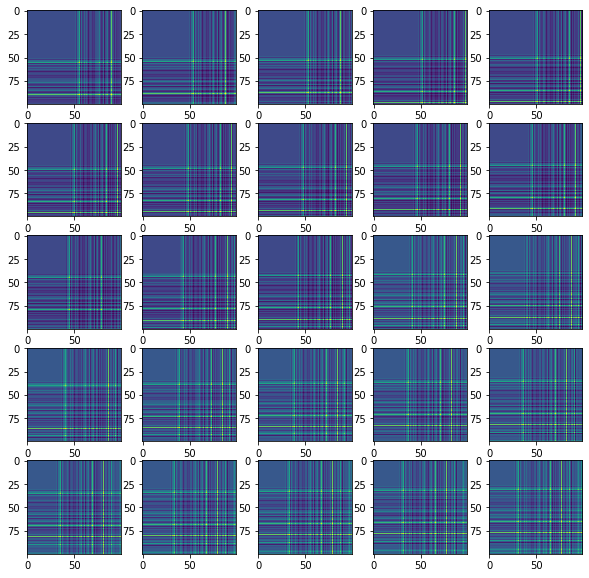

In [5]:
from pyts.image import GramianAngularField

gasf = GramianAngularField(image_size=100, sample_range=(0, 1), method='summation')
X_gasf = gasf.fit_transform(df_train_X.to_numpy()[4500000:5000000])

#print((df_train['open_channels'][7225:7250]))
fig = plt.figure(figsize=(10, 10))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5+j+1)
        plt.imshow(X_gasf[i*5+j])

In [6]:
print(X_gasf.shape)

(500000, 100, 100)


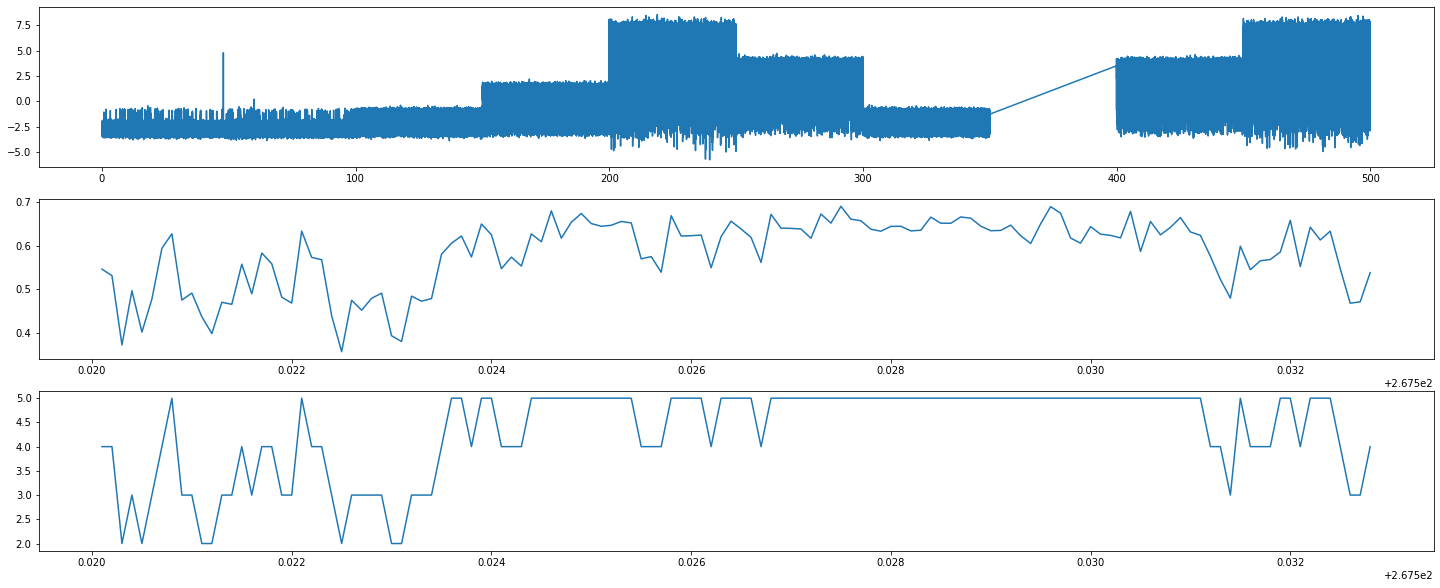

In [26]:
from sklearn.preprocessing import MinMaxScaler

seg = 20900

plt.figure(figsize=(25, 10))
plt.subplot(3, 1, 1)
#plt.plot(df_train.time[seg*500000:(seg+1)*500000], df_train.signal[seg*500000:(seg+1)*500000])
plt.plot(df_train.time, df_train.signal)

plt.subplot(3, 1, 2)
#plt.plot(df_train.time[seg*128:(seg+1)*128], df_train.detrended[seg*128:(seg+1)*128])
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(np.expand_dims(df_train.signal.to_numpy(), 1))
plt.plot(df_train.time[seg*128:(seg+1)*128], X_train[seg*128:(seg+1)*128])

plt.subplot(3, 1, 3)
#plt.plot(df_train.time[seg*500000:(seg+1)*500000], df_train.open_channels[seg*500000:(seg+1)*500000])
plt.plot(df_train.time[seg*128:(seg+1)*128], df_train.open_channels[seg*128:(seg+1)*128])

0.0     1158237
1.0      705679
3.0      560518
2.0      424116
4.0      403410
5.0      277877
7.0      265015
8.0      245183
6.0      188112
9.0      136120
10.0      35733
Name: open_channels, dtype: int64


<BarContainer object of 11 artists>

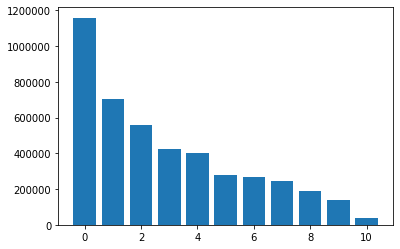

In [30]:
nuniq = df_train.open_channels.value_counts()
print(nuniq)
plt.bar(range(len(nuniq)), list(nuniq))

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-pa

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

# taken ResNet block but changed it to 1D
def get_model_res(input_shape, optimizer):
    
    def res_block(X, n_filters, conv_skip=False):
        X_skip = X
        if conv_skip:
            X_skip = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X_skip)
            X_skip = BatchNormalization()(X_skip)
            X_skip = Activation('relu')(X_skip)
        
        X = Conv1D(filters=n_filters[0], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[1], kernel_size=3, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Add()([X, X_skip])
        X = Activation('relu')(X)
        
        return X
        
    X_input = Input(shape=input_shape)
    X = Conv1D(filters=256, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2)(X)
    
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [64, 64, 128], conv_skip=True)
    X = MaxPool1D(pool_size=2)(X)
    
    X = res_block(X, [64, 64, 128])
    X = res_block(X, [64, 64, 128])
    X = res_block(X, [64, 64, 128])
    X = res_block(X, [32, 32, 64], conv_skip=True)
    X = MaxPool1D(pool_size=2)(X)
    
    X = Bidirectional(GRU(128))(X)
    
    #X = Flatten()(X)
    #X = Dense(128, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(11, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='ResLSTM')
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


# basic CNN
def get_model_images(input_shape, optimizer):

    X_input = Input(shape=input_shape)
    
    X = Conv2D(filters=128, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2)(X)
    
    X = Conv2D(filters=256, kernel_size=3, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2)(X)
    
    X = Conv2D(filters=128, kernel_size=3, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2)(X)

    X = Flatten()(X)
    X = Dense(512)(X)
    X = Dense(11, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='conv2d')
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# taken from paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8141873
def get_model_conv_twice(input_shape, optimizer):
    
    def conv1d(layer_input, filters, k_size=3, strides=1, bn=True):
        d = Conv1D(filters, kernel_size=k_size, strides=strides, padding='same')(layer_input)
        if bn:
            d = BatchNormalization(momentum=0.99, epsilon=0.001)(d)
        d = Activation('relu')(d)
        #d = LeakyReLU(alpha=0.2)(d)
        return d
    
    x_input = Input(shape=input_shape)
    x_in_lstm = Permute((2, 1))(x_input)
    
    X = conv1d(x_input, 128, 1)
    X = conv1d(X, 256, 32, 2)
    X = conv1d(X, 256, 16, 2)
    X = conv1d(X, 256, 8, 2)
    X = conv1d(X, 512, 5, 2)
    X = conv1d(X, 256, 3, 2)
    X = GlobalAveragePooling1D()(X)
    
    x = conv1d(x_in_lstm, 128, 1)
    x = conv1d(x, 256, 32, 2)
    x = conv1d(x, 256, 16, 2)
    x = conv1d(x, 256, 8, 2)
    x = conv1d(x, 512, 5, 2)
    x = conv1d(x, 256, 3, 2)
    x = GlobalAveragePooling1D()(x)
    
    #x = Bidirectional(GRU(256, return_sequences=True))(x_in_lstm)
    #x = Bidirectional(GRU(256))(x)
    #x = Dropout(0.8)(x)
    
    x = Concatenate()([x, X])
    #x = Dense(512)(x)
    x = Reshape((1, 512))(x)
    x = Bidirectional(GRU(64))(x)
    #x = Dense(512)(x)
    x = Dense(256)(x)
    x = Dropout(rate=0.2)(x)
    output = Dense(11, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# https://ieeexplore.ieee.org/abstract/document/8875282
def get_model_fcn_gru(input_shape, optimizer):
    
    def conv1d(layer_input, filters, k_size=3, strides=1, bn=True):
        d = Conv1D(filters, kernel_size=k_size, strides=strides, padding='same', kernel_initializer='he_uniform')(layer_input)
        if bn:
            d = BatchNormalization()(d)
        d = Activation('relu')(d)
        return d
    
    x_input = Input(shape=input_shape)

    X = conv1d(x_input, 128, 8, 1)
    X = conv1d(X, 256, 5, 1)
    X = conv1d(X, 128, 3, 1)
    X = GlobalAveragePooling1D()(X)
    
    x_in_lstm = Permute((2, 1))(x_input)
    x = GRU(128)(x_in_lstm)
    x = Dropout(0.2)(x)
    
    x = Concatenate()([x, X])
    #x = Dropout(rate=0.2)(x)
    output = Dense(11, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


# https://github.com/ronakvijay/Protein_Sequence_Classification/blob/master/Pfam_protein_sequence_classification.ipynb
# taken from above link, ProtCNN model
def get_model_ProtCNN(input_shape, optimizer):
    
    def residual_block(data, filters, d_rate):
        shortcut = data

        bn1 = BatchNormalization()(data)
        act1 = Activation('relu')(bn1)
        conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

        #bottleneck convolution
        bn2 = BatchNormalization()(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

        #skip connection
        x = Add()([conv2, shortcut])

        return x
        
    x_input = Input(shape=input_shape)

    #initial conv
    conv = Conv1D(128, 1, padding='same')(x_input) 

    # per-residue representation
    res1 = residual_block(conv, 128, 2)
    res2 = residual_block(res1, 128, 3)

    x = MaxPooling1D(3)(res2)
    x = Dropout(0.5)(x)
    
    #x = Bidirectional(GRU(128))(x) # my added

    # softmax classifier
    x = Flatten()(x)
    x_output = Dense(11, activation='softmax', kernel_regularizer=l2(0.0001))(x)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


# resnet blocks but for seq to seq translation
def get_model_seq2seq(input_shape, optimizer):
    
    def res_block(X, n_filters, conv_skip=False):
        X_skip = X
        if conv_skip:
            X_skip = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X_skip)
            X_skip = BatchNormalization()(X_skip)
            X_skip = Activation('relu')(X_skip)
        
        X = Conv1D(filters=n_filters[0], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[1], kernel_size=3, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Add()([X, X_skip])
        X = Activation('relu')(X)
        
        return X
        
    X_input = Input(shape=input_shape)
    X = Conv1D(filters=256, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [64, 64, 128], conv_skip=True)
    
    X = Bidirectional(GRU(64, return_sequences=True))(X)
    
    X = Conv1D(filters=1, kernel_size=1, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Add()([X, X_input])
    
    X = Flatten()(X)
    #X = Dropout(0.2)(X)
    X = Dense(input_shape[0], activation='relu')(X)

    model = Model(inputs=X_input, outputs=X, name='sig2sig')
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model


# generator from: https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py
def get_model_unet(input_shape, optimizer):

    def conv2d(layer_input, filters, f_size=3, bn=True):
        """Layers used during downsampling"""
        d = Conv1D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=3, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling1D(size=2)(layer_input)
        u = Conv1D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Add()([u, skip_input])
        return u
    
    n_filters = 64

    # Image input
    d0 = Input(shape=input_shape)

    # Downsampling
    d1 = conv2d(d0, n_filters, bn=False)
    d2 = conv2d(d1, n_filters*2)
    d3 = conv2d(d2, n_filters*4)
    d4 = conv2d(d3, n_filters*8)
    d5 = conv2d(d4, n_filters*8)
    d6 = conv2d(d5, n_filters*8)
    d7 = conv2d(d6, n_filters*8)

    # Upsampling
    u1 = deconv2d(d7, d6, n_filters*8)
    u2 = deconv2d(u1, d5, n_filters*8)
    u3 = deconv2d(u2, d4, n_filters*8)
    u4 = deconv2d(u3, d3, n_filters*4)
    u5 = deconv2d(u4, d2, n_filters*2)
    u6 = deconv2d(u5, d1, n_filters)

    u7 = UpSampling1D(size=2)(u6)
    
    #u7 = Bidirectional(GRU(64, return_sequences=True))(u7)
    
    output_img = Conv1D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(u7)
    output_img = Flatten()(output_img)

    model = Model(inputs=d0, outputs=output_img, name='sig2sig')
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model


def get_model_wavenet(input_shape, optimizer):
    
    def WaveNetResidualConv1D(num_filters, kernel_size, stacked_layer):
        def build_residual_block(l_input):
            resid_input = l_input
            for dilation_rate in [2**i for i in range(stacked_layer)]:
                l_sigmoid_conv1d = Conv1D(
                  num_filters, kernel_size, dilation_rate=dilation_rate,
                  padding='same', activation='sigmoid')(l_input)
                l_tanh_conv1d = Conv1D(
                 num_filters, kernel_size, dilation_rate=dilation_rate,
                 padding='same', activation='tanh')(l_input)
                l_input = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
                l_input = Conv1D(num_filters, 1, padding='same')(l_input)
                resid_input = Add()([resid_input, l_input])
            return resid_input
        return build_residual_block
    
    num_filters_ = 32 # 16
    kernel_size_ = 3
    #stacked_layers_ = [12, 8, 4, 1]
    stacked_layers_ = [6, 4, 2, 1]
    
    l_input = Input(shape=(input_shape))
    
    x = Conv1D(num_filters_, 1, padding='same')(l_input)
    x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
    
    x = Conv1D(num_filters_*2, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
    
    x = Conv1D(num_filters_*4, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
    
    x = Conv1D(num_filters_*8, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)
    x = GlobalAveragePooling1D()(x)
    
    x_input = Permute((2, 1))(l_input)
    X = Conv1D(num_filters_, 1, padding='same')(x_input)
    X = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(X)
    
    X = Conv1D(num_filters_*2, 1, padding='same')(X)
    X = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(X)
    
    X = Conv1D(num_filters_*4, 1, padding='same')(X)
    X = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(X)
    
    X = Conv1D(num_filters_*8, 1, padding='same')(X)
    X = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(X)
    X = GlobalAveragePooling1D()(X)
    
    x = Concatenate()([x, X])
    x = Flatten()(x)
    l_output = Dense(11, activation='softmax')(x)
    
    model = Model(inputs=[l_input], outputs=[l_output])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


# resnet taken from https://github.com/hfawaz/ijcnn19ensemble/blob/master/src/classifiers/resnet.py
def get_model_deep(input_shape, optimizer):

    # input for wavenet
    x_input = Input(input_shape)
    # input for resnet
    #input_layer = Permute((2, 1))(x_input)
    
    # WAVENET
    def WaveNetResidualConv1D(num_filters, kernel_size, stacked_layer):
        def build_residual_block(l_input):
            resid_input = l_input
            for dilation_rate in [2**i for i in range(stacked_layer)]:
                l_sigmoid_conv1d = Conv1D(
                  num_filters, kernel_size, dilation_rate=dilation_rate,
                  padding='same', activation='sigmoid')(l_input)
                l_tanh_conv1d = Conv1D(
                 num_filters, kernel_size, dilation_rate=dilation_rate,
                 padding='same', activation='tanh')(l_input)
                l_input = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
                l_input = Conv1D(num_filters, 1, padding='same')(l_input)
                resid_input = Add()([resid_input, l_input])
            return resid_input
        return build_residual_block
    
    num_filters_ = 64 # 16
    kernel_size_ = 3
    #stacked_layers_ = [12, 8, 4, 1]
    stacked_layers_ = [10, 8, 4, 2]
    
    X = Conv1D(num_filters_, 1, padding='same')(x_input)
    X = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(X)
    X = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(X)
    
    X = Conv1D(num_filters_*2, 1, padding='same')(X)
    X = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(X)
    X = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(X)
    X = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(X)
    
    X = Conv1D(num_filters_*4, 1, padding='same')(X)
    X = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(X)
    X = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(X)
    X = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(X)
    X = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(X)
    
    X = Conv1D(num_filters_*8, 1, padding='same')(X)
    X = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(X)
    X = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(X)
    X = GlobalAveragePooling1D()(X)
    
    # RESNET
    n_feature_maps = 64
    
    def resnet_block(n_feature_maps, input_layer, final_activation=True):
        conv_x = Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
        conv_x = BatchNormalization()(conv_x)
        conv_x = Activation('relu')(conv_x)

        conv_y = Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        conv_y = BatchNormalization()(conv_y)
        conv_y = Activation('relu')(conv_y)

        conv_z = Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        conv_z = BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        shortcut_y = BatchNormalization()(shortcut_y)

        output_block_1 = Add()([shortcut_y, conv_z])
        if final_activation:
            output_block_1 = Activation('relu')(output_block_1)
        return output_block_1
    
    #x = resnet_block(n_feature_maps, input_layer)
    #x = resnet_block(n_feature_maps*2, x)
    #x = resnet_block(n_feature_maps*2, x)
    #x = resnet_block(n_feature_maps*4, x)
    #x = resnet_block(n_feature_maps*4, x, final_activation=False)
    #gap_layer = GlobalAveragePooling1D()(x)
    
    # join both models
    #X = Activation('relu')(X)
    #gap_layer = Activation('tanh')(gap_layer)
    #X = Multiply()([X, gap_layer])
    
    X = Dense(128, activation='relu')(X)

    output_layer = Dense(11, activation='softmax')(X)

    model = Model(inputs=x_input, outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


# https://github.com/hfawaz/InceptionTime/blob/master/classifiers/inception.py
def get_model(input_shape, optimizer):
    
    #out = Lambda(lambda x: x[:, n:m])(input)
    #out = tf.keras.backend.gather(input, [:, n:m])
    
    # set these for each fold individually
    kernel_size = 40 # 20
    use_bottleneck = True
    use_residual = True
    bottleneck_size = 32
    nb_filters = 100 # 64
    depth = 9 # 6
    
    
    def inception_module(input_tensor, stride=1, activation='linear'):

        if use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=bottleneck_size, kernel_size=1, padding='same', 
                                     activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i], strides=stride, padding='same', 
                                    activation=activation, use_bias=False)(input_inception))

        max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = Conv1D(filters=nb_filters, kernel_size=1, padding='same', 
                        activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        return x

    def shortcut_layer(input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1, padding='same', use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)

        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x
    
    x_input = Input(input_shape)

    x = x_input
    input_res = x_input

    for d in range(depth):

        x = inception_module(x)

        if use_residual and d % 3 == 2:
            x = shortcut_layer(input_res, x)
            input_res = x

    gap_layer = GlobalAveragePooling1D()(x)
    
    output_layer = Dense(11, activation='softmax')(gap_layer)

    model = Model(inputs=x_input, outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model
    

In [5]:
from tensorflow.keras.callbacks import Callback

class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=-1)
        
    def on_epoch_end(self, epoch, logs={}):
        preds = np.argmax(self.model.predict(self.inputs), axis=-1)
        score = f1_score(self.targets, preds, average='macro')
        print(f' - val_macro_F1: {score:.5f}')

In [6]:
import numpy as np

#TODO maybe: change the code so that sequences are created here instead of above
# creates a batch of bootstrapped examples
# doesn't take data batches into account & have to pad test data
def batch_generator(batch_size, X, y, n_before, n_after):
    while True:
        # Allocate a new array for the batch of input-signals.
        seq_len = n_before + 1 + n_after
        x_shape = (batch_size, seq_len, X.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, y.shape[1])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(n_before, X.shape[0] - n_after)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X[idx-n_before:idx+n_after+1]
            y_batch[i] = y[idx]
        
        #print(x_batch.shape)
        yield (x_batch, y_batch)
        

# prototype idea taken from: https://www.sciencedirect.com/science/article/pii/S0031320319303279
def batch_generator_with_prototypes(batch_size, X, y, n_before, n_after, prototype_indices):
    from dtw import dtw
    
    # get indices of each class (classes[i] = indices of ith class)
    classes = []
    for clsn in range(11):
        indices = np.where(np.argmax(y, axis=-1) == clsn)[0]
        classes.append(indices[(indices >= n_before) & (indices < X.shape[0] - n_after)])
        #print(f'entries for class {clsn}: {len(indices)}')
    
    while True:
        # Set prototypes for each class
        #prototype_indices = [np.random.choice(classes[clsn]) for clsn in range(11)]
        
        # Allocate a new array for the batch of input-signals.
        seq_len = n_before + 1 + n_after
        padded_len = 2*seq_len - 1
        
        x_shape = (batch_size, padded_len, 1+11)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, y.shape[1])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(n_before, X.shape[0] - n_after)
            
            # Copy the sequences of data starting at this index.
            signal = X[idx-n_before:idx+n_after+1, 0]
            x_batch[i, :, 0] = np.pad(signal, (0, padded_len-seq_len))
            for clsn in range(11):
                prototype = X[prototype_indices[clsn]-n_before:prototype_indices[clsn]+n_after+1, 0]
                dtw_obj = dtw(signal, prototype)
                dists = np.abs(signal[dtw_obj.index1] - prototype[dtw_obj.index2])
                x_batch[i, :, clsn+1] = np.pad(dists, (0, padded_len-len(dists)))
            y_batch[i] = y[idx]
        
        #print(x_batch.shape)
        yield (x_batch, y_batch)


# generates input and output sequences for signal-to-signal translation
def seq2seq_generator(batch_size, X, y, seq_len):
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, seq_len, 1)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, seq_len)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(X.shape[0] - seq_len)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X[idx:idx+seq_len]
            y_batch[i] = y[idx:idx+seq_len]
        
        #print(x_batch.shape)
        yield (x_batch, y_batch)

#X = np.array([[1, 11], [2, 22], [3, 33], [4, 44], [5, 55]])
#y = np.array([[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]])
#gen = batch_generator(2, X, y, 1, 2)
#print(next(gen))

#X = np.array([[1], [2], [3], [4], [5], [6]])
#y = np.array([1, 2, 3, 4, 5, 6])
#gen = seq_generator(2, X, y, 3)
#print(next(gen))

# X = np.array([[0, 0], [0, 0], [1, 11], [2, 22], [3, 33], [4, 44], [5, 55], 
#              [6, 11], [7, 22], [8, 33], [9, 44], [10, 55], 
#              [11, 11], [12, 22], [13, 33], [14, 44]])
# y = np.array([[0]*0 + [1] + [0]*10, [0]*0 + [1] + [0]*10, [0]*1 + [1] + [0]*9, [0]*2 + [1] + [0]*8, [0]*3 + [1] + [0]*7, 
#              [0]*4 + [1] + [0]*6, 
#              [0]*5 + [1] + [0]*5, [0]*6 + [1] + [0]*4, [0]*7 + [1] + [0]*3, [0]*8 + [1] + [0]*2, [0]*9 + [1] + [0]*1, 
#              [0]*10 + [1] + [0]*0, [0]*0 + [1] + [0]*10, [0]*5 + [1] + [0]*5, [0]*3 + [1] + [0]*7, [0]*4 + [1] + [0]*6])
# gen = batch_generator_with_prototypes(2, X, y, 1, 1)
# print(next(gen))

full shape: X  (5000000, 110) , y  (5000000,)
Training 1. Fold
X_train shape:  (4000000, 110)
y_train shape:  (4000000, 11)
X_test shape:  (24390, 41, 110)
y_test shape:  (24390, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 41, 110)      0                                            
__________________________________________________________________________________________________
conv1d_240 (Conv1D)             (None, 41, 32)       3520        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPooling1D) (None, 41, 110)      0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_241 (Conv1D)      

Epoch 1/200
24390/24390 [==============================] - 7s 288us/sample - loss: 0.2181 - acc: 0.9171

Epoch 00001: val_loss improved from inf to 0.21814, saving model to best_model_1fold.h5
2000/2000 [==============================] - 111s 55ms/step - loss: 0.5207 - acc: 0.7771 - val_loss: 0.2181 - val_acc: 0.9171
Epoch 2/200
24390/24390 [==============================] - 7s 307us/sample - loss: 1.1327 - acc: 0.6314

Epoch 00002: val_loss did not improve from 0.21814
2000/2000 [==============================] - 87s 43ms/step - loss: 0.2050 - acc: 0.9190 - val_loss: 1.1331 - val_acc: 0.6314
Epoch 3/200
24390/24390 [==============================] - 7s 300us/sample - loss: 0.2312 - acc: 0.9152

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_loss did not improve from 0.21814
2000/2000 [==============================] - 89s 45ms/step - loss: 0.1738 - acc: 0.9327 - val_loss: 0.2313 - val_acc: 0.9152
Epoch 4/200
24390/24390 [=============

Epoch 27/200
24390/24390 [==============================] - 7s 298us/sample - loss: 0.0901 - acc: 0.9656

Epoch 00027: val_loss did not improve from 0.08958
2000/2000 [==============================] - 86s 43ms/step - loss: 0.0884 - acc: 0.9654 - val_loss: 0.0901 - val_acc: 0.9656
Epoch 28/200
24390/24390 [==============================] - 7s 303us/sample - loss: 0.0894 - acc: 0.9661s - loss: 0.0746 - ac

Epoch 00028: val_loss improved from 0.08958 to 0.08939, saving model to best_model_1fold.h5
2000/2000 [==============================] - 87s 44ms/step - loss: 0.0865 - acc: 0.9665 - val_loss: 0.0894 - val_acc: 0.9661
Epoch 29/200
24390/24390 [==============================] - 7s 294us/sample - loss: 0.0899 - acc: 0.9658s - lo

Epoch 00029: val_loss did not improve from 0.08939
2000/2000 [==============================] - 87s 43ms/step - loss: 0.0884 - acc: 0.9662 - val_loss: 0.0899 - val_acc: 0.9658
Epoch 30/200
24390/24390 [==============================] - 7s 291us/sample - loss: 0.

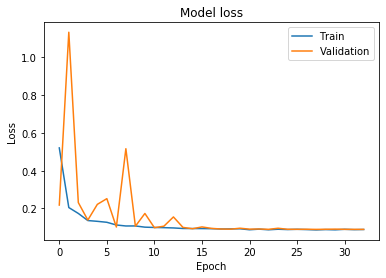

Training 2. Fold
X_train shape:  (4000000, 110)
y_train shape:  (4000000, 11)
X_test shape:  (24390, 41, 110)
y_test shape:  (24390, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 41, 110)      0                                            
__________________________________________________________________________________________________
conv1d_288 (Conv1D)             (None, 41, 32)       3520        input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_54 (MaxPooling1D) (None, 41, 110)      0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_289 (Conv1D)             (None, 41, 100)      128000      conv1d

Epoch 1/200
24390/24390 [==============================] - 8s 331us/sample - loss: 0.7245 - acc: 0.7235

Epoch 00001: val_loss improved from inf to 0.72455, saving model to best_model_2fold.h5
2000/2000 [==============================] - 121s 61ms/step - loss: 0.4681 - acc: 0.8013 - val_loss: 0.7246 - val_acc: 0.7235
Epoch 2/200
24390/24390 [==============================] - 7s 290us/sample - loss: 0.6146 - acc: 0.7670

Epoch 00002: val_loss improved from 0.72455 to 0.61475, saving model to best_model_2fold.h5
2000/2000 [==============================] - 88s 44ms/step - loss: 0.1976 - acc: 0.9217 - val_loss: 0.6147 - val_acc: 0.7670
Epoch 3/200
24390/24390 [==============================] - 7s 306us/sample - loss: 0.2668 - acc: 0.8911

Epoch 00003: val_loss improved from 0.61475 to 0.26700, saving model to best_model_2fold.h5
2000/2000 [==============================] - 91s 45ms/step - loss: 0.1710 - acc: 0.9329 - val_loss: 0.2670 - val_acc: 0.8911
Epoch 4/200
24390/24390 [============

Epoch 27/200
24390/24390 [==============================] - 7s 269us/sample - loss: 0.0828 - acc: 0.9688

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00027: val_loss did not improve from 0.08234
2000/2000 [==============================] - 85s 43ms/step - loss: 0.0880 - acc: 0.9654 - val_loss: 0.0829 - val_acc: 0.9688
Epoch 28/200
24390/24390 [==============================] - 7s 268us/sample - loss: 0.0824 - acc: 0.9692

Epoch 00028: val_loss did not improve from 0.08234
2000/2000 [==============================] - 84s 42ms/step - loss: 0.0885 - acc: 0.9660 - val_loss: 0.0825 - val_acc: 0.9692
Epoch 29/200
24390/24390 [==============================] - 7s 268us/sample - loss: 0.0820 - acc: 0.9693

Epoch 00029: val_loss improved from 0.08234 to 0.08212, saving model to best_model_2fold.h5
2000/2000 [==============================] - 84s 42ms/step - loss: 0.0881 - acc: 0.9655 - val_loss: 0.0821 - val_acc: 0.9693
Epoch 30/200
24390/24390 [=====

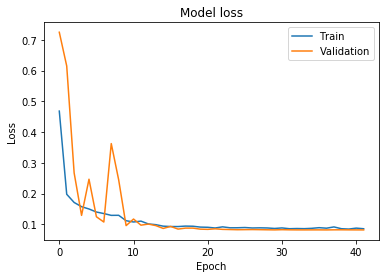

Training 3. Fold
X_train shape:  (4000000, 110)
y_train shape:  (4000000, 11)
X_test shape:  (24390, 41, 110)
y_test shape:  (24390, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 41, 110)      0                                            
__________________________________________________________________________________________________
conv1d_336 (Conv1D)             (None, 41, 32)       3520        input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_63 (MaxPooling1D) (None, 41, 110)      0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_337 (Conv1D)             (None, 41, 100)      128000      conv1d

Epoch 1/200
24390/24390 [==============================] - 7s 306us/sample - loss: 0.5568 - acc: 0.7983

Epoch 00001: val_loss improved from inf to 0.55717, saving model to best_model_3fold.h5
2000/2000 [==============================] - 123s 61ms/step - loss: 0.4797 - acc: 0.7965 - val_loss: 0.5572 - val_acc: 0.7983
Epoch 2/200
24390/24390 [==============================] - 7s 276us/sample - loss: 0.2018 - acc: 0.9223

Epoch 00002: val_loss improved from 0.55717 to 0.20194, saving model to best_model_3fold.h5
2000/2000 [==============================] - 84s 42ms/step - loss: 0.2064 - acc: 0.9183 - val_loss: 0.2019 - val_acc: 0.9223
Epoch 3/200
24390/24390 [==============================] - 7s 278us/sample - loss: 0.3813 - acc: 0.8594

Epoch 00003: val_loss did not improve from 0.20194
2000/2000 [==============================] - 84s 42ms/step - loss: 0.1810 - acc: 0.9293 - val_loss: 0.3814 - val_acc: 0.8594
Epoch 4/200
24390/24390 [==============================] - 8s 327us/sample - l

Epoch 27/200
24390/24390 [==============================] - 8s 313us/sample - loss: 0.0672 - acc: 0.9752

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00027: val_loss did not improve from 0.06678
2000/2000 [==============================] - 89s 44ms/step - loss: 0.0955 - acc: 0.9632 - val_loss: 0.0673 - val_acc: 0.9752
Epoch 28/200
24390/24390 [==============================] - 8s 314us/sample - loss: 0.0671 - acc: 0.9750

Epoch 00028: val_loss did not improve from 0.06678
2000/2000 [==============================] - 89s 44ms/step - loss: 0.0941 - acc: 0.9637 - val_loss: 0.0672 - val_acc: 0.9750
Epoch 00028: early stopping
val_macro_f1: 0.944505264489795


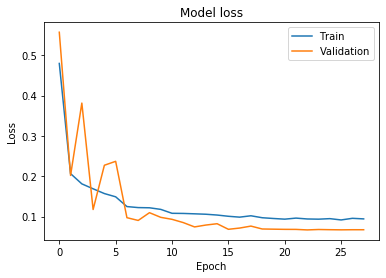

Training 4. Fold
X_train shape:  (4000000, 110)
y_train shape:  (4000000, 11)
X_test shape:  (24390, 41, 110)
y_test shape:  (24390, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 41, 110)      0                                            
__________________________________________________________________________________________________
conv1d_384 (Conv1D)             (None, 41, 32)       3520        input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_72 (MaxPooling1D) (None, 41, 110)      0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_385 (Conv1D)             (None, 41, 100)      128000      conv1d

Epoch 1/200
24390/24390 [==============================] - 8s 344us/sample - loss: 0.3901 - acc: 0.8368

Epoch 00001: val_loss improved from inf to 0.39026, saving model to best_model_4fold.h5
2000/2000 [==============================] - 139s 70ms/step - loss: 0.5063 - acc: 0.7843 - val_loss: 0.3903 - val_acc: 0.8368
Epoch 2/200
24390/24390 [==============================] - 7s 297us/sample - loss: 0.1375 - acc: 0.9492

Epoch 00002: val_loss improved from 0.39026 to 0.13757, saving model to best_model_4fold.h5
2000/2000 [==============================] - 89s 44ms/step - loss: 0.2151 - acc: 0.9147 - val_loss: 0.1376 - val_acc: 0.9492
Epoch 3/200
24390/24390 [==============================] - 7s 286us/sample - loss: 0.2253 - acc: 0.9160

Epoch 00003: val_loss did not improve from 0.13757
2000/2000 [==============================] - 89s 44ms/step - loss: 0.1862 - acc: 0.9264 - val_loss: 0.2254 - val_acc: 0.9160
Epoch 4/200
24390/24390 [==============================] - 7s 292us/sample - l

24390/24390 [==============================] - 8s 326us/sample - loss: 0.0647 - acc: 0.9759

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00027: val_loss did not improve from 0.06426
2000/2000 [==============================] - 92s 46ms/step - loss: 0.0963 - acc: 0.9624 - val_loss: 0.0648 - val_acc: 0.9759
Epoch 28/200
24390/24390 [==============================] - 8s 326us/sample - loss: 0.0641 - acc: 0.9759

Epoch 00028: val_loss improved from 0.06426 to 0.06417, saving model to best_model_4fold.h5
2000/2000 [==============================] - 93s 46ms/step - loss: 0.0940 - acc: 0.9634 - val_loss: 0.0642 - val_acc: 0.9759
Epoch 29/200
24390/24390 [==============================] - 8s 326us/sample - loss: 0.0648 - acc: 0.9759

Epoch 00029: val_loss did not improve from 0.06417
2000/2000 [==============================] - 92s 46ms/step - loss: 0.0960 - acc: 0.9627 - val_loss: 0.0649 - val_acc: 0.9759
Epoch 30/200
24390/24390 [==============================] - 8

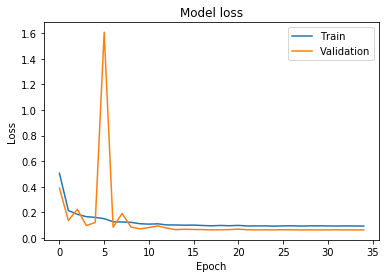

Training 5. Fold
X_train shape:  (4000000, 110)
y_train shape:  (4000000, 11)
X_test shape:  (24390, 41, 110)
y_test shape:  (24390, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 41, 110)      0                                            
__________________________________________________________________________________________________
conv1d_432 (Conv1D)             (None, 41, 32)       3520        input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_81 (MaxPooling1D) (None, 41, 110)      0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_433 (Conv1D)             (None, 41, 100)      128000      conv1d

Epoch 1/200
24390/24390 [==============================] - 9s 381us/sample - loss: 0.6902 - acc: 0.7304s 

Epoch 00001: val_loss improved from inf to 0.69047, saving model to best_model_5fold.h5
2000/2000 [==============================] - 149s 74ms/step - loss: 0.4675 - acc: 0.7989 - val_loss: 0.6905 - val_acc: 0.7304
Epoch 2/200
24390/24390 [==============================] - 8s 329us/sample - loss: 0.2205 - acc: 0.9182

Epoch 00002: val_loss improved from 0.69047 to 0.22049, saving model to best_model_5fold.h5
2000/2000 [==============================] - 92s 46ms/step - loss: 0.1891 - acc: 0.9251 - val_loss: 0.2205 - val_acc: 0.9182
Epoch 3/200
24390/24390 [==============================] - 7s 300us/sample - loss: 0.1760 - acc: 0.9333

Epoch 00003: val_loss improved from 0.22049 to 0.17603, saving model to best_model_5fold.h5
2000/2000 [==============================] - 88s 44ms/step - loss: 0.1620 - acc: 0.9363 - val_loss: 0.1760 - val_acc: 0.9333
Epoch 4/200
24390/24390 [==========

Epoch 27/200
24390/24390 [==============================] - 7s 300us/sample - loss: 0.1008 - acc: 0.9614

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00027: val_loss improved from 0.10089 to 0.10083, saving model to best_model_5fold.h5
2000/2000 [==============================] - 89s 44ms/step - loss: 0.0833 - acc: 0.9690 - val_loss: 0.1008 - val_acc: 0.9614
Epoch 28/200
24390/24390 [==============================] - 7s 299us/sample - loss: 0.1011 - acc: 0.9607

Epoch 00028: val_loss did not improve from 0.10083
2000/2000 [==============================] - 88s 44ms/step - loss: 0.0839 - acc: 0.9670 - val_loss: 0.1012 - val_acc: 0.9607
Epoch 29/200
24390/24390 [==============================] - 7s 301us/sample - loss: 0.1009 - acc: 0.9610

Epoch 00029: val_loss did not improve from 0.10083
2000/2000 [==============================] - 88s 44ms/step - loss: 0.0817 - acc: 0.9683 - val_loss: 0.1010 - val_acc: 0.9610
Epoch 30/200
24390/24390 [======================

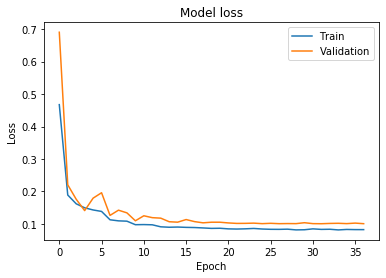

In [9]:
# FOR CLASSIFICATION (N-length signal -> 1 label)
#TODO shuffle training set somehow
#TODO split training set to training and validation

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, StratifiedShuffleSplit, GroupKFold, GroupShuffleSplit
from sklearn.metrics import f1_score

# macro f1 score with one-hot encoded labels
def macro_f1(yoh_true, yoh_pred):
    y_true = np.argmax(yoh_true, axis=-1)
    y_pred = np.argmax(yoh_pred, axis=-1)
    return f1_score(y_true, y_pred, average='macro')

# numpy data for training
seg = 0
# features = ['signal', 'signal_2', 'diff', 'diff_2', #'signal_root2', 'signal_abs', 
#             'rolling_mean_11', 'rolling_mean_101', 'rolling_mean_1001', 'rolling_mean_10001', 
#             'rolling_std_11', 'rolling_std_101', 'rolling_std_1001', 'rolling_std_10001', 
#             'rolling_var_11', 'rolling_var_101', 'rolling_var_1001', 'rolling_var_10001', 
#             'rolling_min_11', 'rolling_min_101', 'rolling_min_1001', 'rolling_min_10001', 
#             'rolling_max_11', 'rolling_max_101', 'rolling_max_1001', 'rolling_max_10001', 
#             'rolling_min_max_ratio_11', 'rolling_min_max_ratio_101', 'rolling_min_max_ratio_1001', 'rolling_min_max_ratio_10001', 
#             'rolling_max_min_diff_11', 'rolling_max_min_diff_101', 'rolling_max_min_diff_1001', 'rolling_max_min_diff_10001', 
#             'norm_11', 'norm_101', 'norm_1001', 'norm_10001', 
#             'rolling_sum_11', 'rolling_sum_101', 'rolling_sum_1001', 'rolling_sum_10001'
# ]

n_before = 20
n_after = 20
SEQ_LEN = n_before + 1 + n_after

X = df_train[features].to_numpy()#[seg*500000:(seg+1)*500000]
y = df_train.open_channels.astype(np.uint8).to_numpy()#[seg*500000:(seg+1)*500000]
y_oh = to_categorical(y, num_classes=11)
groups = df_train.group.to_numpy()#[seg*500000:(seg+1)*500000]
print('full shape: X ', X.shape, ', y ', y.shape)
#print(y)

model_zoo = []

# cross validation training
oof_true = np.empty((0, 11))
oof_pred = np.empty((0, 11))
#kf = GroupKFold(n_splits=9)
kf = GroupShuffleSplit(n_splits=5, random_state=1)
#kf = KFold(n_splits=5)
#kf = StratifiedKFold(n_splits=5)
#kf = StratifiedShuffleSplit(n_splits=5, random_state=1)
for kth, (train_index, val_index) in enumerate(kf.split(X, y, groups)):
    print(f'Training {kth+1}. Fold')
    #print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    #y_train, y_test = y[train_index], y[val_index]
    yoh_train, yoh_test = y_oh[train_index], y_oh[val_index]
    
    # scale data to (-1, 1) range and reshape
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    # reshape validation data
    n_val_samples = yoh_test.shape[0] // SEQ_LEN * SEQ_LEN
    X_test = X_test[:n_val_samples].reshape((-1, SEQ_LEN, len(features)))
    idx = np.array(range(0, n_val_samples, SEQ_LEN)) + n_before
    yoh_test = yoh_test[idx]
    
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', yoh_train.shape)
    print('X_test shape: ', X_test.shape)
    print('y_test shape: ', yoh_test.shape)
    
    batch_size = 50 # 128
    gen = batch_generator(batch_size, X_train, yoh_train, n_before, n_after)
    
    # init model
    opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) # 0.001
    model = get_model((SEQ_LEN, len(features)), opt_adam)
    
    # define model callbacks
    callback_checkpoint = ModelCheckpoint(filepath=f'best_model_{kth+1}fold.h5', 
                               monitor='val_loss', 
                               verbose=1, 
                               #save_weights_only=True, 
                               save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                           factor=0.5, 
                                           patience=2, # 0
                                           verbose=1, 
                                           min_delta=1e-4, 
                                           min_lr=1e-5)
    callback_tensorboard = TensorBoard(log_dir=f'./logs_{kth}fold/', histogram_freq=0, write_graph=False)
    callback_macro_f1 = MacroF1(model, X_test, yoh_test)
    #cbs = [callback_checkpoint, callback_early_stopping, callback_reduce_lr, callback_tensorboard]
    cbs = [callback_early_stopping, callback_reduce_lr, callback_checkpoint]
    
    # train model
    history = model.fit(x=gen, 
                        epochs=200, 
                        steps_per_epoch=100_000//batch_size, # 100_000
                        verbose=1, 
                        validation_data=(X_test, yoh_test), 
                        callbacks=cbs)
    
    # calculate macro f1 on val set
    yoh_pred = model.predict(X_test)
    score = macro_f1(yoh_test, yoh_pred)
    print(f'val_macro_f1: {score}')
    
    model_zoo.append(model)
    
    # append to oof arrays
    oof_true = np.append(oof_true, yoh_test, axis=0)
    oof_pred = np.append(oof_pred, yoh_pred, axis=0)
    
    # plot loss and val_loss wrt epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [10]:
print('y_oof shape: ', oof_true.shape)
print('OOF Macro F1: ', macro_f1(oof_true, oof_pred))
# OOF Macro F1:  0.932929468391941 with no batch 7

y_oof shape:  (121950, 11)
OOF Macro F1:  0.9393691306767006


In [20]:
for i, model in enumerate(model_zoo):
    model.save(f'model_fold_{i+1}.h5')

In [ ]:
yoh_pred = model.predict(X_test)
print(yoh_pred.shape)

#plt.figure(figsize=(25, 10))
#plt.plot(np.arange(SEQ_LEN), np.squeeze(X_test[220] * 10), color='blue', linewidth=10)
#plt.plot(np.arange(SEQ_LEN), y_test[220] * 10, color='orange', linewidth=5)
#plt.plot(np.arange(SEQ_LEN), np.rint(yoh_pred[220] * 10), color='black')

print(macro_f1(yoh_test, yoh_pred))

full shape: X= (4500000, 36) , y= (4500000,)
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1001, 36)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1001, 32)     1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1001, 32)     3104        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1001, 32)     3104        conv1d[0][0]              

Epoch 1/30
781/781 [==============================] - 415s 532ms/step - loss: 0.9632 - acc: 0.5726
Epoch 2/30
781/781 [==============================] - 410s 525ms/step - loss: 0.4585 - acc: 0.8015
Epoch 3/30
781/781 [==============================] - 409s 524ms/step - loss: 0.1947 - acc: 0.9212
Epoch 4/30
781/781 [==============================] - 409s 524ms/step - loss: 0.1684 - acc: 0.9327
Epoch 5/30
780/781 [============================>.] - ETA: 0s - loss: 0.1546 - acc: 0.9387
Epoch 00005: saving model to model_epoch_5.h5
781/781 [==============================] - 418s 535ms/step - loss: 0.1547 - acc: 0.9386
Epoch 6/30
781/781 [==============================] - 409s 524ms/step - loss: 0.1529 - acc: 0.9405
Epoch 7/30
781/781 [==============================] - 409s 524ms/step - loss: 0.1463 - acc: 0.9432
Epoch 8/30
780/781 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.9425
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
781/781 [=

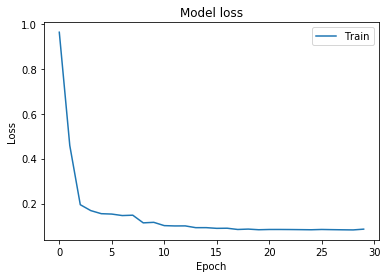

In [8]:
# train on whole train set
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score

# macro f1 score with one-hot encoded labels
def macro_f1(yoh_true, yoh_pred):
    y_true = np.argmax(yoh_true, axis=-1)
    y_pred = np.argmax(yoh_pred, axis=-1)
    return f1_score(y_true, y_pred, average='macro')

# numpy data for training
seg = 0
#features = ['signal', 'signal_sq', 'signal_sqroot', 
#            'rolling_mean_1001', 'rolling_std_1001', 'rolling_var_1001', 'rolling_min_1001', 'rolling_max_1001', 
#            'rolling_min_max_ratio_1001', 'rolling_max_min_diff_1001', 'norm_1001']
features = ['signal', 'signal_sq', 'signal_sqroot', 'signal_abs', 
            'rolling_mean_11', 'rolling_std_11', 'rolling_var_11', 'rolling_min_11', 'rolling_max_11', 
            'rolling_min_max_ratio_11', 'rolling_max_min_diff_11', 'norm_11', 
            
            'rolling_mean_101', 'rolling_std_101', 'rolling_var_101', 'rolling_min_101', 'rolling_max_101', 
            'rolling_min_max_ratio_101', 'rolling_max_min_diff_101', 'norm_101', 
            
            'rolling_mean_1001', 'rolling_std_1001', 'rolling_var_1001', 'rolling_min_1001', 'rolling_max_1001', 
            'rolling_min_max_ratio_1001', 'rolling_max_min_diff_1001', 'norm_1001',
           
            'rolling_mean_10001', 'rolling_std_10001', 'rolling_var_10001', 'rolling_min_10001', 'rolling_max_10001', 
            'rolling_min_max_ratio_10001', 'rolling_max_min_diff_10001', 'norm_10001'
]
n_before = 500
n_after = 500
SEQ_LEN = n_before + 1 + n_after

X = df_train[features].to_numpy()#[seg*500000:(seg+1)*500000]
y = df_train.open_channels.to_numpy()#[seg*500000:(seg+1)*500000]
y_oh = to_categorical(y, num_classes=11)

groups = df_train.batch.to_numpy()#[seg*500000:(seg+1)*500000]
print('full shape: X=', X.shape, ', y=', y.shape)
#print(y)
    
# scale data to (-1, 1) range and reshape
x_scaler = MinMaxScaler(feature_range=(0, 1))
X = x_scaler.fit_transform(X)

batch_size = 128
gen = batch_generator(batch_size, X, y_oh, n_before, n_after)

# init model
opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model = get_model((SEQ_LEN, len(features)), opt_adam)

# define model callbacks
callback_checkpoint = ModelCheckpoint(filepath='model_epoch_{epoch}.h5', verbose=1, period=5)
callback_early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
callback_reduce_lr = ReduceLROnPlateau(monitor='loss', 
                                       factor=0.5, 
                                       patience=0, 
                                       verbose=1, 
                                       min_delta=1e-4, 
                                       min_lr=1e-5)
callback_tensorboard = TensorBoard(log_dir=f'./logs/', histogram_freq=0, write_graph=False)
#cbs = [callback_checkpoint, callback_early_stopping, callback_reduce_lr, callback_tensorboard]
cbs = [callback_reduce_lr, callback_checkpoint]

# train model
history = model.fit(x=gen, 
                    epochs=30, 
                    steps_per_epoch=100_000//batch_size, 
                    verbose=1, 
                    callbacks=cbs)

# plot loss and val_loss wrt epoch
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [11]:
del df_train

#model.save('wave_net_all_feats_full_train.h5')

In [12]:
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np

def save_submission(y_test):
    #submission = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv")
    submission = pd.read_csv("sample_submission.csv")
    submission["open_channels"] = np.asarray(y_test, dtype=np.int32)
    submission.to_csv("submission.csv", index=False, float_format="%.4f")

def new_data_batch(df, batch_size, start_idx):
    # create X
    X = np.zeros((batch_size, SEQ_LEN, len(features)))
    for i in range(batch_size):
        X[i] = df.iloc[start_idx+i:start_idx+i+SEQ_LEN, :]

    return X



df_new = pd.read_csv("test_clean_kalman.csv")

df_new_feats = pd.read_csv('test_clean_kalman_feats_w101.csv').drop(columns='Unnamed: 0')
df_new_feats['signal'] = df_new['signal']

df_new = df_new_feats

n_examples = df_new.shape[0]
#df_new = gen_features(df_new, window_sizes)
# scale the data
df_new = pd.DataFrame(x_scaler.transform(df_new[features].to_numpy()))
# extend df with n_before and n_after rows
df_new = pd.concat([pd.DataFrame([df_new.iloc[0, :]]*n_before), df_new, pd.DataFrame([df_new.iloc[-1, :]]*n_after)], 
                   ignore_index=True)

# load model
model_zoo = [tf.keras.models.load_model(f'best_model_{i+1}fold.h5') for i in range(5)]
#model = tf.keras.models.load_model('model_epoch_15.h5')

new_batch_size = 500
y_new = np.empty((0, 11))
for i in tqdm(range(n_examples // new_batch_size)):
    X_new = new_data_batch(df_new, new_batch_size, i*new_batch_size)
    preds = []
    for model in model_zoo:
        preds.append(model.predict(X_new))
    y_new = np.append(y_new, np.sum(preds, axis=0), axis=0)
y_new = np.argmax(y_new, axis=-1)
save_submission(y_new)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [1:19:06<00:00,  1.16s/it]


In [6]:
# FOR SIGNAL-TO-SIGNAL TRANSLATION
#TODO split training set to training and validation

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score

# macro f1 score
def macro_f1(y_true, y_pred):
    y_true = np.rint(y_true.reshape(-1))
    y_pred = np.rint(y_pred.reshape(-1))
    return f1_score(y_true, y_pred, average='macro')

# numpy data for training
seg = 9

X = df_train.signal.to_numpy()#[seg*500000:(seg+1)*500000]
X = X[:, np.newaxis]

y = df_train.open_channels.to_numpy()#[seg*500000:(seg+1)*500000]
y_oh = to_categorical(y, num_classes=11)

#print(X.shape, y.shape)
#print(y)

SEQ_LEN = 4096

# cross validation training
scores = []
#kf = GroupKFold(n_splits=10)
#kf = KFold(n_splits=2)
#kf = StratifiedKFold(n_splits=5)
kf = StratifiedShuffleSplit(n_splits=5, random_state=0)
for kth, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f'Training {kth+1}. Fold')
    #print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]
    #yoh_train, yoh_test = y_oh[train_index], y_oh[val_index]
    
    # scale data to (0, 1) range and reshape
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    y_train = y_train / 10
    y_test = y_test / 10
    
    # reshape validation data
    n_val_samples = y_test.shape[0] // SEQ_LEN * SEQ_LEN
    X_test = X_test[:n_val_samples].reshape((-1, SEQ_LEN, 1))
    y_test = y_test[:n_val_samples].reshape((-1, SEQ_LEN))
    
    # for classification
    #X_train = X_train.reshape((-1, SEQ_LEN, 1))
    #X_test = X_test.reshape((-1, SEQ_LEN, 1))
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    
    batch_size = 128
    gen = seq2seq_generator(batch_size, X_train, y_train, SEQ_LEN)
    
    # init model
    opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model = get_model((SEQ_LEN, 1), opt_adam)
    
    # define model callbacks
    callback_checkpoint = ModelCheckpoint(filepath=f'best_model_{kth}fold.h5', 
                               monitor='val_loss', 
                               verbose=1, 
                               save_weights_only=True, 
                               save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                           factor=0.5, 
                                           patience=0, 
                                           verbose=1, 
                                           min_delta=1e-4, 
                                           min_lr=1e-5)
    callback_tensorboard = TensorBoard(log_dir=f'./logs_{kth}fold/', histogram_freq=0, write_graph=False)
    #callback_macro_f1 = MacroF1(model, X_test, yoh_test)
    #cbs = [callback_checkpoint, callback_early_stopping, callback_reduce_lr, callback_tensorboard]
    cbs = [callback_early_stopping, callback_reduce_lr]
    
    
    
    # train model
    history = model.fit(x=gen, 
                        epochs=200, 
                        steps_per_epoch=100_000//batch_size, 
                        verbose=1, 
                        validation_data=(X_test, y_test), 
                        callbacks=cbs)
    
    # calculate macro f1 on val set
    y_pred = model.predict(X_test)
    score = macro_f1(y_test * 10, y_pred * 10)
    print(f'val_macro_f1: {score}')
    scores.append(score)
    
    # plot loss and val_loss wrt epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
print(scores)
print(np.mean(scores))

Training 1. Fold
X_train shape:  (4500000, 1)
y_train shape:  (4500000,)
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4096, 1)      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 2048, 64)     256         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 2048, 64)     0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 1024, 128)    24704       leaky_re_lu_7[0][0]   

Epoch 1/200
781/781 [==============================] - 250s 320ms/step - loss: 0.0092 - mean_absolute_error: 0.0647 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525
Epoch 2/200
781/781 [==============================] - 253s 323ms/step - loss: 0.0055 - mean_absolute_error: 0.0504 - val_loss: 0.0054 - val_mean_absolute_error: 0.0490
Epoch 3/200
781/781 [==============================] - 262s 335ms/step - loss: 0.0053 - mean_absolute_error: 0.0478 - val_loss: 0.0053 - val_mean_absolute_error: 0.0472
Epoch 4/200
122/122 [==============================] - 0s 736us/sample - loss: 0.0052 - mean_absolute_error: 0.0459

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
781/781 [==============================] - 242s 310ms/step - loss: 0.0052 - mean_absolute_error: 0.0464 - val_loss: 0.0052 - val_mean_absolute_error: 0.0459
Epoch 5/200
781/781 [==============================] - 240s 307ms/step - loss: 0.0051 - mean_absolute_error: 0.0456 - val_loss: 0.0052 - va

KeyboardInterrupt: 

(122, 4096)
0.5808597210665313


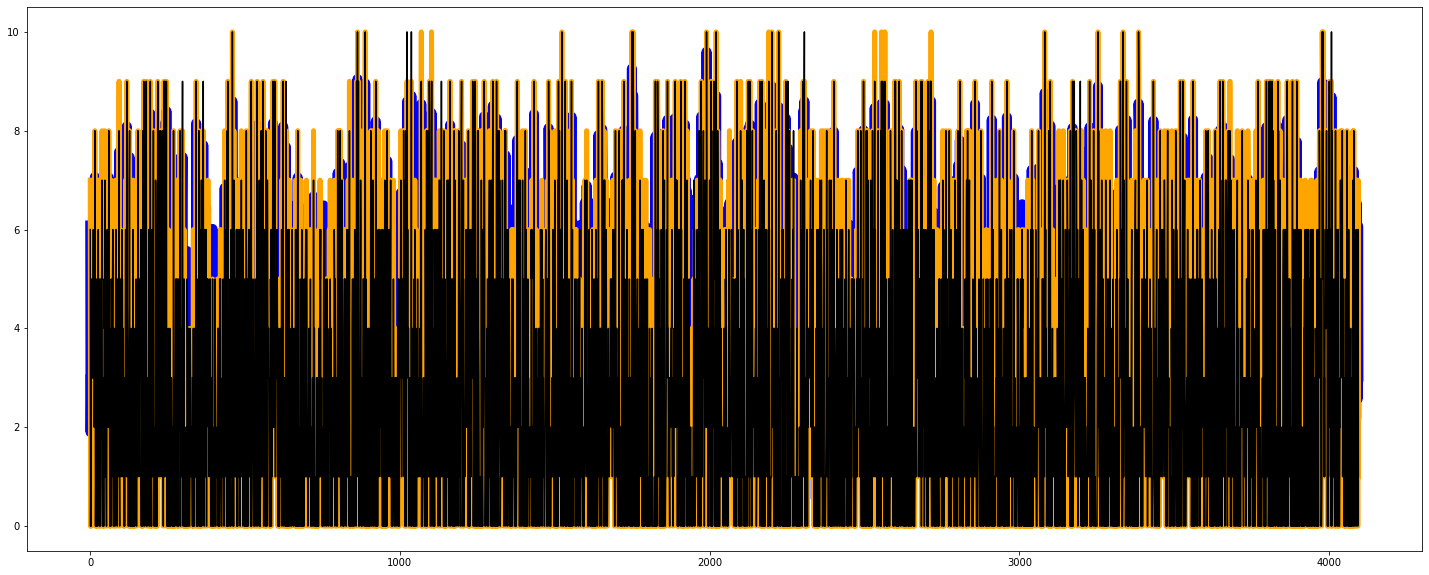

In [8]:
yoh_pred = model.predict(X_test)
print(yoh_pred.shape)

plt.figure(figsize=(25, 10))
plt.plot(np.arange(SEQ_LEN), np.squeeze(X_test[20] * 10), color='blue', linewidth=10)
plt.plot(np.arange(SEQ_LEN), y_test[20] * 10, color='orange', linewidth=5)
plt.plot(np.arange(SEQ_LEN), np.rint(yoh_pred[20] * 10), color='black')

print(f1_score(np.rint(y_test.reshape(-1) * 10), np.rint(yoh_pred.reshape(-1) * 10), average='macro'))